In [338]:
!pip install pandas matplotlib seaborn folium geopandas icecream

In [339]:
import folium
import geopandas as gpd
import pandas as pd
import random
import numpy as np
from folium.plugins import MarkerCluster
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from icecream import ic

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import warnings
warnings.filterwarnings("ignore")


data = pd.read_csv('./drive/MyDrive/HouseFit/sao-paulo-properties-april-2019.csv')
df_services = pd.read_json('./drive/MyDrive/HouseFit/essentialServicesSP.json')
geojson_path = "./drive/MyDrive/HouseFit/geojs-35-mun.json"  # Substitua pelo caminho correto
sp_borders_gdf = gpd.read_file(geojson_path)
mapa_sp = folium.Map(location=[-23.55, -46.63], zoom_start=11, control_scale=True)


In [340]:
df_rent = data[data['Negotiation Type'] == 'rent']
df_sale = data[data['Negotiation Type'] == 'sale']

df_rent_bkp = df_rent.copy()
df_sale_bkp = df_sale.copy()
print(f"SALE: {df_sale['Price'].min()} - {df_sale['Price'].max()}, {df_sale['Price'].mean()}")
print(f"RENT: {df_rent['Price'].min()} - {df_rent['Price'].max()}, {df_rent['Price'].mean()}")

SALE: 42000 - 10000000, 608624.1400499064
RENT: 480 - 50000, 3077.6690647482014


In [341]:
data['Negotiation Type'].value_counts()

,count
Negotiation Type,
rent,7228
sale,6412


In [342]:
sale_mean = round(float(df_sale.describe()['Price']['mean']), 2)
rent_mean = round(float(df_rent.describe()['Price']['mean']), 2)
sale_mean, rent_mean

(608624.14, 3077.67)

In [343]:
# quantidade de imoveis abaixo da media geral de preço
sale_above_mean = len(df_sale.loc[df_sale['Price'] <= sale_mean]['Price'])
rent_above_mean = len(df_rent.loc[df_rent['Price'] <= rent_mean]['Price'])
sale_above_mean, rent_above_mean

(4551, 5297)

In [344]:
percentage_sale_above_mean = round((sale_above_mean / df_sale.shape[0])*100, 2)
percentage_rent_sale_above_mean = round((rent_above_mean / df_rent.shape[0])*100, 2)
percentage_sale_above_mean, percentage_rent_sale_above_mean

(70.98, 73.28)

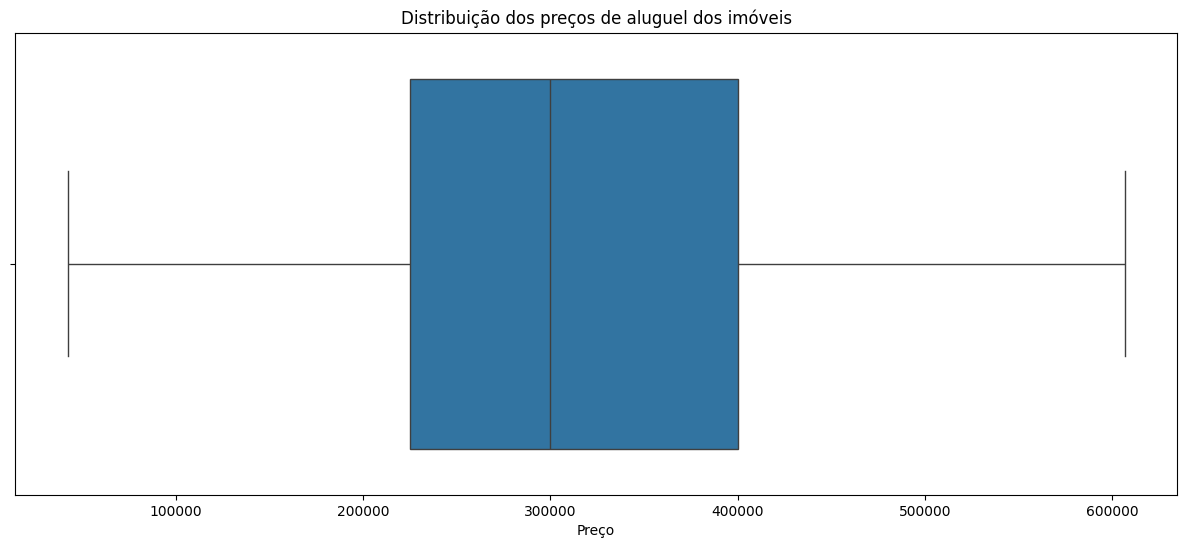

ic| Q1_sale: np.float64(232999.2)
ic| Q3_sale: np.float64(1200000.0)
ic| IQR_sale: np.float64(967000.8)
ic| bottom_limit_sale: np.float64(39599.03999999998)
ic| upper_limit_sale: np.float64(2457101.04)
ic| df_sale['Price'].mean(): np.float64(320738.12700505386)
ic| df_sale['Price'].min(): 42000
ic| df_sale['Price'].max(): 606760


606760

In [345]:
# Calcular o primeiro e terceiro quartil
Q1_sale = df_sale["Price"].quantile(0.2)
Q3_sale = df_sale["Price"].quantile(0.9)
IQR_sale = Q3_sale - Q1_sale

# Definir limites para remoção de outliers
bottom_limit_sale = Q1_sale - 0.2 * IQR_sale
upper_limit_sale = Q3_sale + 1.3 * IQR_sale

# Filtrar os dados removendo os outliers
df_sale = df_sale[(df_sale["Price"] >= bottom_limit_sale) & (df_sale["Price"] <= sale_mean)]

plt.figure(figsize=(15,6))
sns.boxplot(df_sale['Price'], orient='h')
plt.title('Distribuição dos preços de aluguel dos imóveis')
plt.xlabel('Preço')
plt.show()

ic(Q1_sale)
ic(Q3_sale)
ic(IQR_sale)
ic(bottom_limit_sale)
ic(upper_limit_sale)
ic(df_sale['Price'].mean())
ic(df_sale['Price'].min())
ic(df_sale['Price'].max())

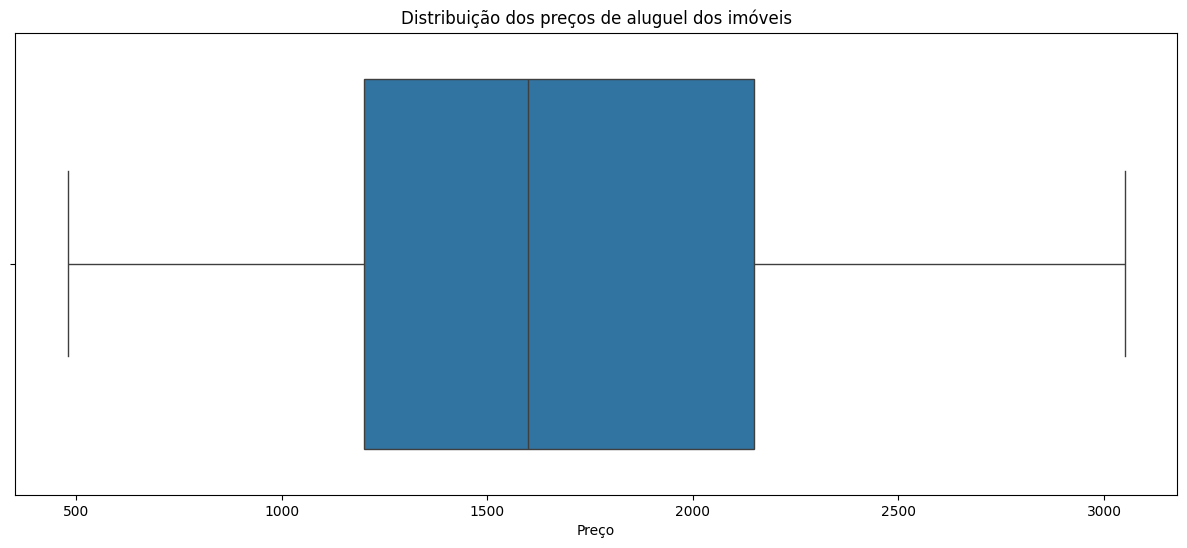

ic| Q1_rent: np.float64(1250.0)
ic| Q3_rent: np.float64(6000.0)
ic| IQR_rent: np.float64(4750.0)
ic| bottom_limit_rent: np.float64(300.0)
ic| upper_limit_rent: np.float64(13125.0)
ic| df_rent['Price'].mean(): np.float64(1714.5588068718143)
ic| df_rent['Price'].min(): 480
ic| df_rent['Price'].max(): 3050


3050

In [346]:
# Calcular o primeiro e terceiro quartil
Q1_rent = df_rent["Price"].quantile(0.2)
Q3_rent = df_rent["Price"].quantile(0.9)
IQR_rent = Q3_rent - Q1_rent

# Definir limites para remoção de outliers
bottom_limit_rent = Q1_rent - 0.2 * IQR_rent
upper_limit_rent = Q3_rent + 1.5 * IQR_rent

# Filtrar os dados removendo os outliers
df_rent = df_rent[(df_rent["Price"] >= bottom_limit_rent) & (df_rent["Price"] <= rent_mean)]

plt.figure(figsize=(15,6))
sns.boxplot(df_rent['Price'], orient='h')
plt.title('Distribuição dos preços de aluguel dos imóveis')
plt.xlabel('Preço')
plt.show()

ic(Q1_rent)
ic(Q3_rent)
ic(IQR_rent)
ic(bottom_limit_rent)
ic(upper_limit_rent)
ic(df_rent['Price'].mean())
ic(df_rent['Price'].min())
ic(df_rent['Price'].max())

In [347]:
Q1_rent, Q1_sale, Q3_rent, 1.3 * Q3_sale

(np.float64(1250.0),
 np.float64(232999.2),
 np.float64(6000.0),
 np.float64(1560000.0))

In [348]:
print(f"SALE: {df_sale['Price'].min()} - {df_sale['Price'].max()}, {df_sale['Price'].mean()}")
print(f"RENT: {df_rent['Price'].min()} - {df_rent['Price'].max()}, {df_rent['Price'].mean()}")

SALE: 42000 - 606760, 320738.12700505386
RENT: 480 - 3050, 1714.5588068718143


In [349]:
df = pd.concat([df_rent, df_sale], ignore_index=True)

df['Negotiation Type'] = df['Negotiation Type'].map({'sale': 0, 'rent': 1})

encoder = LabelEncoder()
df['District'] = encoder.fit_transform(df['District'])

In [350]:
df.shape

(9848, 16)

In [351]:
df.loc[:, ~df.columns.isin(list(df.select_dtypes(include=['object']).columns))].corr()['Price'].sort_values(ascending=True)

,Price
Negotiation Type,-0.886873
Condo,-0.156493
Size,-0.043978
Latitude,-0.021443
Longitude,-0.021219
District,-0.009319
Parking,-0.007507
Furnished,-0.000819
Toilets,0.023129
Suites,0.023972


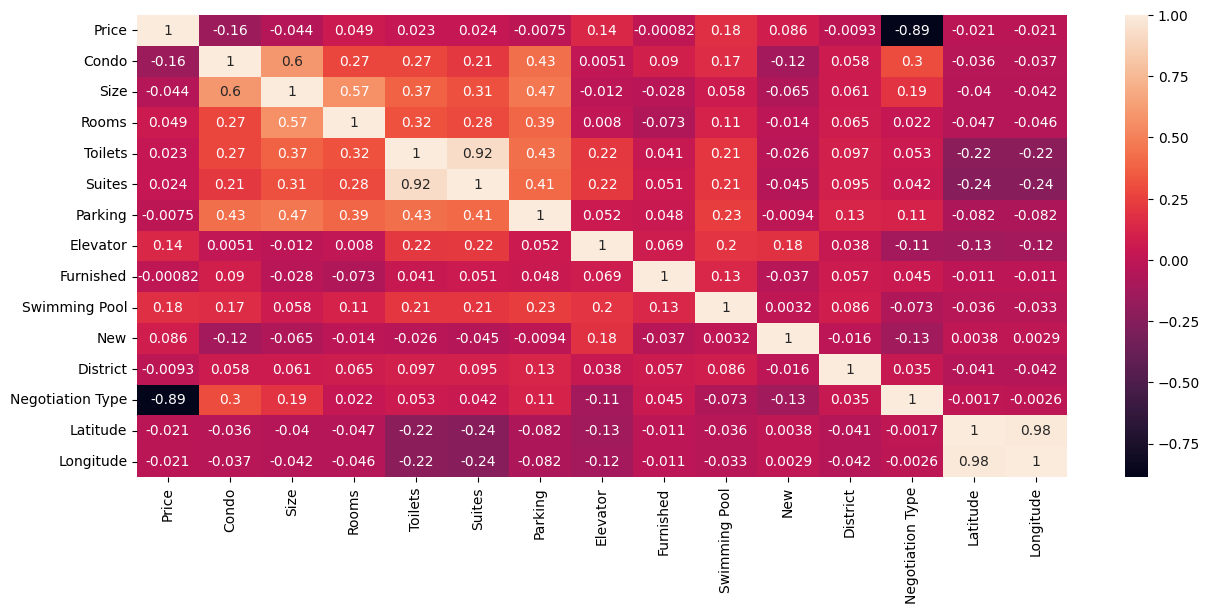

In [352]:
plt.figure(figsize=(15,6))
sns.heatmap(df.loc[:, ~df.columns.isin(list(df.select_dtypes(include=['object']).columns))].corr(), annot=True)
plt.show()

In [353]:
df = df.drop(['Property Type', 'Latitude', 'Longitude', 'Furnished',  'Elevator', 'New'], axis=1)
df.shape, print("SALE PERCENTAGE: ", len(df_sale)/len(df)), print(f"SALE REDUCTION PERC {len(df_sale)/len(df_sale_bkp)}"), print("DF SALE TOTAL: ", len(df_sale)),  print(f"RENT REDUCTION PERC {len(df_rent)/len(df_rent_bkp)}"), print("DF RENT TOTAL: ", len(df_rent))

SALE PERCENTAGE:  0.4621242891957758
SALE REDUCTION PERC 0.7097629444791017
DF SALE TOTAL:  4551
RENT REDUCTION PERC 0.7328444936358606
DF RENT TOTAL:  5297


((9848, 10), None, None, None, None, None)

In [354]:
pt = PowerTransformer(method='yeo-johnson')
df['Price'] = np.log1p(df['Price'])

In [355]:
X = df.drop('Price', axis=1)
y = df['Price'].values.reshape(-1, 1)

y = pt.fit_transform(y)

# Separar as colunas numéricas e categóricas
num_features = X.columns.drop("Negotiation Type")  # Excluir "Negotiation Type" do escalonamento

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
], remainder='passthrough')  # Mantém "Negotiation Type" sem normalizar

X_processed = preprocessor.fit_transform(X)
X_processed = pd.DataFrame(X_processed, columns=num_features.tolist() + ["Negotiation Type"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, shuffle=True)

X_train_np = X_train.to_numpy()
y_train_np = y_train.reshape(-1, 1)  

X_test_np = X_test.to_numpy()
y_test_np = y_test.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [357]:
X_test_rent.shape[0] + X_test_sale.shape[0]

2955

In [358]:
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.05),

            nn.Linear(128, 96),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Dropout(0.05),


            nn.Linear(96, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 48),
            nn.ReLU(),

            nn.Linear(48, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = HousePriceNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

best_loss = float('inf')
patience, counter = 10, 0

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=300, patience=10):
    train_losses = []
    val_losses = []
    best_loss = float("inf")
    counter = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Treinamento
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        scheduler.step()  # Atualiza a taxa de aprendizado

        train_epoch_loss = running_train_loss / len(train_loader)
        train_losses.append(train_epoch_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                running_val_loss += val_loss.item()

        val_epoch_loss = running_val_loss / len(val_loader)
        val_losses.append(val_epoch_loss)

        # Early stopping
        if train_epoch_loss < best_loss:
            best_loss = train_epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping ativado!")
                break

        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Loss de Treinamento", color="blue")
        plt.plot(val_losses, label="Loss de Validação", color="red")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.title("Evolução da Loss Durante o Treinamento e Validação")
        plt.legend()
        plt.grid(True)
        plt.show()

        if epoch % 20 == 0:
            print(f"Época [{epoch}/{epochs}], Treinamento Loss: {train_epoch_loss:.4f}, Validação Loss: {val_epoch_loss:.4f}")

## SALE AND RENT TRAIN


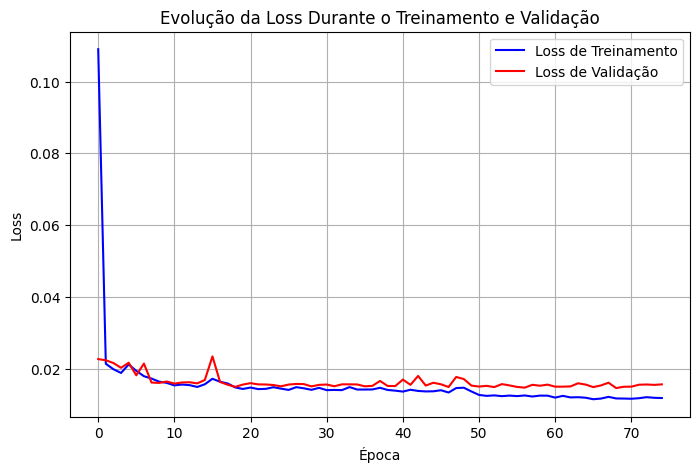

Early stopping ativado!


In [360]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=300, patience=10)

In [ ]:
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_true = y_test_tensor.numpy()

In [ ]:
y_pred = np.expm1(pt.inverse_transform(y_pred))
y_true = np.expm1(pt.inverse_transform(y_true))

In [363]:
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [364]:
print(f'R²: {r2:.4f}')
print(f'MAE: R$ {mae:.2f}')
print(f'RMSE: R$ {rmse:.2f}')

R²: 0.9305
MAE: R$ 24197.07
RMSE: R$ 47331.43


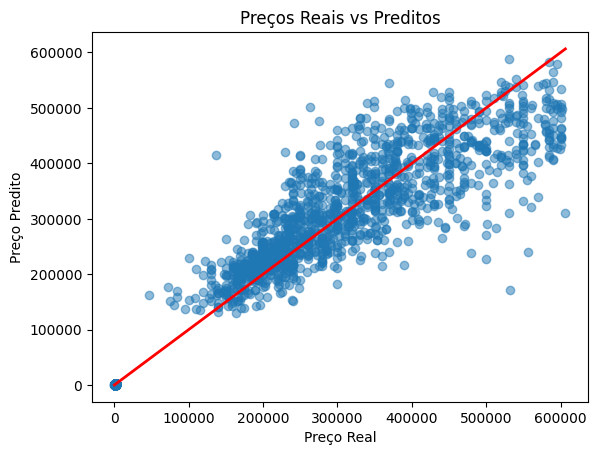

In [ ]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
plt.xlabel('Preço Real')
plt.ylabel('Preço Predito')
plt.title('Preços Reais vs Preditos')
plt.show()
